# Firm Entry and Exit Problem

In [2]:
%matplotlib notebook
import numpy as np
from quantecon.markov.approximation import tauchen
import scipy.optimize as opt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import quantecon
import scipy.interpolate as intpl
from matplotlib import cm
from numba import vectorize, jit, njit, float64, prange

In [3]:
theta = 0.21
mu = 0.64
delta = 0.1
beta = 0.96
varphi = 0.5
rho = 0.9
sigma = 0.02
n_ss = 0.6

### Question 2: Representative Agent Steady State

In [4]:
def get_ss():
    
    r = (1 / beta) - (1 - delta)
    n = n_ss
    eps = 0
    k = (r / ((n ** mu) * theta * np.exp(eps))) ** (1 / (theta - 1))
    y = np.exp(eps) * (k ** theta) * (n ** mu)
    i = delta * k
    c = y - i
    w = mu * y / n
    a = w / c
    
    return k, w 

In [5]:
k_ss, w_ss = get_ss()
print(k_ss)
print(w_ss)

1.0881001887382777
0.7829715643830996


### Question 3: Incumbent Firms' Decision Rule

In [5]:
### k_grid
N_k = 50
k_low =  k_ss - 0.5
k_high = k_ss + 0.5
k_grid = np.linspace(k_low, k_high, N_k)

### eps_grid
## https://lectures.quantecon.org/jl/finite_markov.html
N_eps = 10
trans_eps_MC = tauchen(rho, sigma, n=N_eps).P

sigma_y = np.sqrt( sigma ** 2 / (1 - rho ** 2) )
m = 3
eps_grid = np.zeros(N_eps)
eps_grid[0] = -m * sigma_y
eps_grid[N_eps-1] = m * sigma_y
s = (eps_grid[N_eps-1] - eps_grid[0]) / (N_eps - 1)
for i in range(1, N_eps-1):
    eps_grid[i] = eps_grid[i-1] + s
    

# Now we initialize the value function:
V_init = np.zeros((N_eps, N_k))

In [6]:
k_low

0.5881001887382777

In [7]:
k_high

1.5881001887382777

In [8]:
trans_eps_MC

array([[5.30478170e-01, 4.15375002e-01, 5.32885772e-02, 8.56706028e-04,
        1.54439460e-06, 2.92857183e-10, 5.66213743e-15, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [9.67966302e-02, 4.93930466e-01, 3.69971746e-01, 3.87971726e-02,
        5.03259844e-04, 7.25892202e-07, 1.09655174e-10, 1.66533454e-15,
        0.00000000e+00, 0.00000000e+00],
       [3.71959075e-03, 1.21954964e-01, 5.23228103e-01, 3.23146274e-01,
        2.76615366e-02, 2.89198006e-04, 3.33562232e-07, 4.01295663e-11,
        4.44089210e-16, 0.00000000e+00],
       [2.52812798e-05, 5.78316444e-03, 1.54270165e-01, 5.43701344e-01,
        2.76746317e-01, 1.93110204e-02, 1.62557651e-04, 1.49849563e-07,
        1.43532963e-11, 1.11022302e-16],
       [2.82551739e-08, 4.80546862e-05, 8.83083400e-03, 1.91241547e-01,
        5.54230974e-01, 2.32360418e-01, 1.31987073e-02, 8.93711456e-05,
        6.58100220e-08, 5.01743092e-12],
       [5.01748193e-12, 6.58100220e-08, 8.93711456e-05, 1.31987073e-02,
   

In [9]:
eps_grid

array([-0.13764944, -0.10706068, -0.07647191, -0.04588315, -0.01529438,
        0.01529438,  0.04588315,  0.07647191,  0.10706068,  0.13764944])

In [10]:
n = lambda eps, k: (w / (mu * np.exp(eps) * k ** theta)) ** (1 / (mu - 1))

In [11]:
cf = 0.01
w = w_ss

### Value Function Iteration (with interpolation)

In [12]:
def vf_update(eps_index, k_index, V_old_interp, w, cf):
    """
    input:
    k_index: index so that k_grid[index] corresponds to value of capital this period (state)
    V_old: approximation to the value function. V_old[i] approximates V(k_grid[i]).
    
    output:
    action_value: value of all possible state-action pairs.
    """
    
    ### solve v1
    eps = eps_grid[eps_index]
    k = k_grid[k_index]

    n = (w / (mu*np.exp(eps)*k**theta))**(1/(mu-1))
    action_value = np.zeros((N_k, N_eps))
    
    
    profit = np.exp(eps) * (k ** theta) * (n ** mu) - w * n - (k_grid - (1 - delta) * k) \
        - varphi / 2 * (k_grid / k - (1 - delta)) ** 2 * k 
    
    
    action_value = profit + beta * np.dot((trans_eps_MC[eps_index, :]).T, V_old_interp(eps_grid, k_grid).T)
    
    V1_new = np.max(action_value)
    
    ### solve v_new
    V_new = max((1 - delta) * k, V1_new - cf)
    
    return V_new, action_value

In [13]:
def vf_update_iteration(V_old, V_old_interp, w, cf):
    """
    input: 
    V_old: array with current approximation of the value function
    
    output:
    V_new: updated approximation of the value function
    """
    V_new = np.zeros_like(V_old)
    
    for i in range(N_eps):
        for j in range(N_k):
            V_new[i, j], action_value = vf_update(i, j, V_old_interp, w, cf)

    return V_new

In [14]:
def solve_value_func_iter(w, cf, plot=True):
    difference_list = []
    threshold = 1e-10
    max_iterations = 10000
    plot_interval = 50

    V = V_init.copy()

    for iteration in range(max_iterations):
        
        # x.size = m and y.size = n, if z.ndim == 2, then z must have shape (n, m)
        V_interp = intpl.interp2d(eps_grid, k_grid, V.T, kind='linear')
        V_new = vf_update_iteration(V, V_interp, w, cf)
        #V_new = vf_update_iteration(V, V_interp, w, cf)
        
        
        difference = np.amax(abs(V_new - V))
        # print('Iteration: {}, difference: {}'.format(iteration + 1, difference))

        difference_list.append(difference) 

        V = V_new

        if difference < threshold:
            #print('Converged after iteration {}'.format(iteration + 1))
            #print('Iteration: {}, difference: {}'.format(iteration + 1, difference))
            
            if plot:
                fig = plt.figure()
                ax = fig.gca(projection='3d')
                EPS, K = np.meshgrid(eps_grid, k_grid)
                surf1 = ax.scatter(EPS, K, V.T, cmap=cm.autumn)
                surf2 = ax.plot_surface(EPS, K, (1 - delta) * K)
                #fig.colorbar(surf1, shrink=.5, aspect=5)
                ax.set_xlabel(r'$\epsilon$')
                ax.set_ylabel(r'$k$')
                ax.set_zlabel(r'V')
                ax.set_title("Value Function")
                #plt.show()
                #plt.close()
                    
            break
   
    return V, V_interp
 

### Value Function Plot

<IPython.core.display.Javascript object>


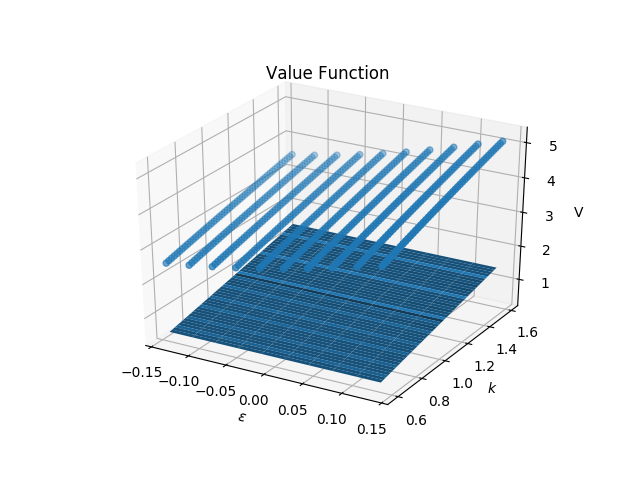

In [15]:
V, V_interp = solve_value_func_iter(w_ss, cf)

### Policy Function

In [16]:
def extract_policy(V, V_interp, w, plot=True):

    poly_grid = np.zeros_like(V)
        
    for i in range(N_eps):
        for j in range(N_k):
            V_new, action_value = vf_update(i, j, V_interp, w, cf)
            
            if V_new == (1 - delta) * k_grid[j]:
                poly_grid[i, j] = 0
            
            else:
                poly_grid[i, j] = k_grid[np.argmax(action_value)]
        
    if plot:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        EPS, K = np.meshgrid(eps_grid, k_grid)
        #surf1 = ax.plot_surface(EPS, K, poly_grid.T, cmap=cm.autumn)
        surf1 = ax.scatter(EPS, K, poly_grid.T, cmap=cm.autumn)
        #fig.colorbar(surf1, shrink=.5, aspect=5)
        #surf1 = ax.plot_wireframe(EPS, K, V.T)
        ax.set_xlabel(r'$\epsilon$')
        ax.set_ylabel(r'$k$')
        ax.set_zlabel(r"$k'$")
        ax.set_title("Capital Accumulation Policy Function")
        
    return poly_grid

### Policy Function Plot

<IPython.core.display.Javascript object>


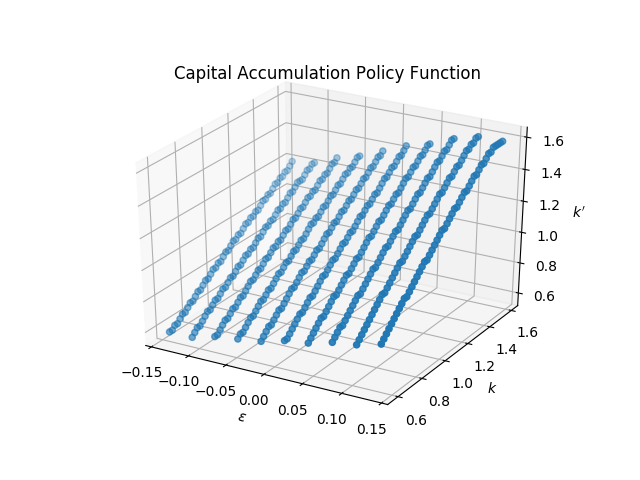

In [17]:
poly_grid = extract_policy(V, V_interp, w)

In [106]:
#poly_grid

### Indicator for whether firm will continue

In [18]:
def firm_continue(eps, k, V_interp):
    V_val = V_interp(eps, k)
    if V_val == (1 - delta) * k:
        return False
    else:
        return True

In [19]:
firm_continue(0, 5, V_interp)

True

In [20]:
firm_continue(0.2, 1, V_interp)

True

In [21]:
def firm_continue_grid(V):
    V_new = np.zeros_like(V)
    for i in range(N_k):
        V_new[:, i] = ((1 - delta) * k_grid[i] != V[:, i]) 
    return V_new

In [22]:
firm_cont_grid = firm_continue_grid(V)

### Function $\hat{V}(\epsilon)$

In [23]:
def get_v_hat(eps, V_interp):
    
    eps_index = np.where(eps_grid == eps)[0][0]
    vals = []
    
    for k_index in range(N_k):
        val = - k_grid[k_index] + beta * np.dot(trans_eps_MC[eps_index, :], V_interp(eps_grid, k_grid[k_index]))
        vals.append(val)
    
    return max(vals)       

In [24]:
get_v_hat(eps_grid[4], V_interp)

2.357045613824444

## Question 4: Market-Clearing Wage

In [25]:
ce = 0.02

In [26]:
### https://dilawarnotes.wordpress.com/2017/11/07/stationary-distribution-of-markov-chains-using-python/
def solveStationary( A ):
    n = A.shape[0]
    a = np.eye( n ) - A
    a = np.vstack( (a.T, np.ones( n )) )
    b = np.matrix( [0] * n + [ 1 ] ).T
    return np.linalg.lstsq( a, b )[0]

#### Stationary Distribution of $\epsilon$

In [27]:
stationary_dist_eps = np.array(solveStationary(trans_eps_MC))
stationary_dist_eps

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


array([[0.00575924],
       [0.02496288],
       [0.07627247],
       [0.16041558],
       [0.23258983],
       [0.23258983],
       [0.16041558],
       [0.07627247],
       [0.02496288],
       [0.00575924]])

In [28]:
np.sum(stationary_dist_eps)

1.0

### Solving for Market-Clearing Wage

In [29]:
def mark_wage_err(w, ce, cf):
    V_new, V_interp_new = solve_value_func_iter(w, cf, plot=False)
    
    V_hats = np.zeros_like(eps_grid)
    # iterate loop in parallel
    
    for i in range(len(eps_grid)):
        V_hats[i] = get_v_hat(eps_grid[i], V_interp_new)
    
    integral = np.dot(V_hats, stationary_dist_eps)
    err = ce - integral
    #print(err)
    return np.array(err)

In [30]:
def solve_mark_wage(w_guess, ce, cf):
    args = (ce, cf)
    result = opt.root(mark_wage_err, w_guess, args = args)
    return result.x[0]

In [31]:
w_star = solve_mark_wage(0.9, 0.02, 0.01)

In [32]:
w_star

1.1477168978636108

## Question 5: Stationary measure of firms and mass of entrants

<IPython.core.display.Javascript object>


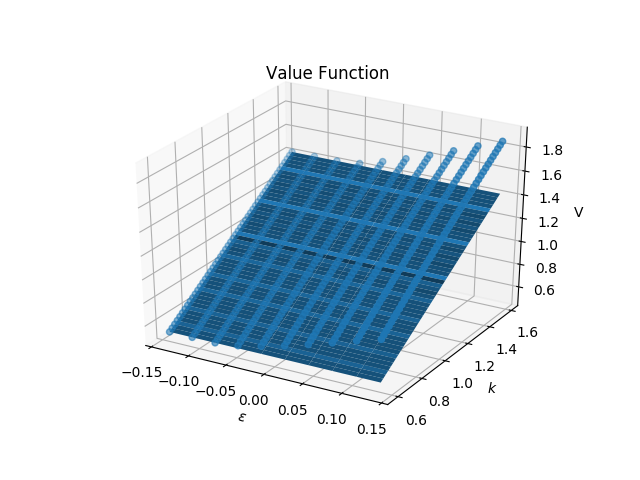

In [33]:
V, V_interp = solve_value_func_iter(w_star, cf)

<IPython.core.display.Javascript object>


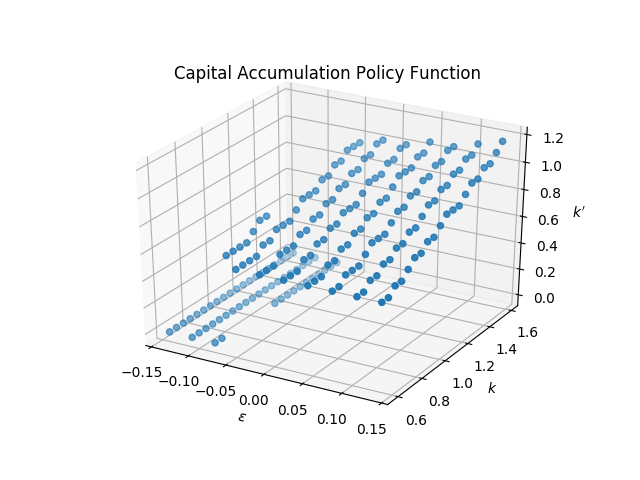

In [214]:
poly_grid = extract_policy(V, V_interp, w_star)

In [34]:
firm_cont_grid = firm_continue_grid(V)
#firm_cont_grid

### Step 1: Solving $g(\epsilon, k)$

In [35]:
g_init = np.random.uniform(low=0, high=1, size=(N_eps, N_k))
g_init = g_init / np.sum(g_init)
g = g_init.copy()
m_star = 1

In [36]:
np.sum(g)

1.0

In [37]:
@jit(nopython=True, parallel=True)
def update_g(g):
    g_new = np.zeros((N_eps, N_k))
    
    # iterate loop in parallel
    for k in range(N_eps):
        for l in range(N_k):
            C = (poly_grid == k_grid[l])
            
            summation = 0
            for i in range(N_eps):
                for j in range(N_k):
                    
                    sum_ij = trans_eps_MC[i,k] * C[i, j] * firm_cont_grid[i, j] * g[i, j] 
                    summation += sum_ij
                    
            summation += m_star * stationary_dist_eps[k][0]
            g_new[k, l] = summation
     
    return g_new

In [38]:
def solve_g(plot=True):
    threshold = 1e-8
    max_iterations = 1000
    diff = 1
    g = g_init.copy()
    
    while (diff > 1e-5):
        g_new = update_g(g) 
        #print('sum :', np.sum(g_new))
        diff = np.max(np.abs(g_new - g))
        #print(diff)
        g = g_new.copy()
    
    g_normalized = g_new / np.sum(g_new)
        
    if plot:
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        EPS, K = np.meshgrid(eps_grid, k_grid)
        surf1 = ax.scatter(EPS, K, g_normalized.T, cmap=cm.autumn)
        #fig.colorbar(surf1, shrink=.5, aspect=5)
        #surf1 = ax.plot_wireframe(EPS, K, g_normalized.T)
        ax.set_xlabel(r'$\epsilon$')
        ax.set_ylabel(r'$k$')
        ax.set_zlabel(r"$g$")
        ax.set_title("Law of Motion g")
        
    return g_normalized

<IPython.core.display.Javascript object>


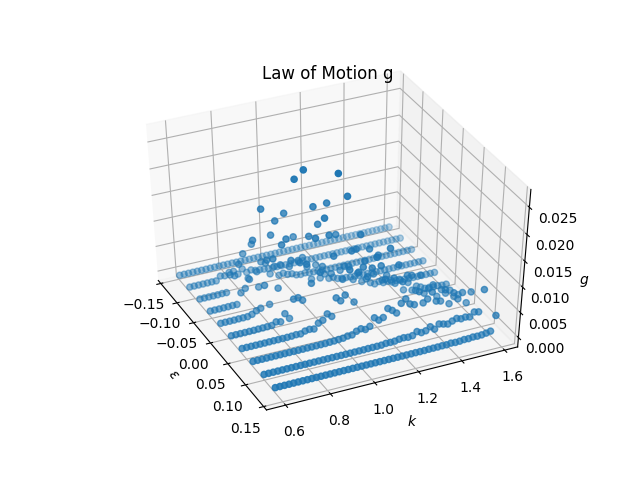

In [39]:
g = solve_g()

### Step 2: Solving m*

In [40]:
def get_g_star(g, m):
    return g.copy() * m

In [41]:
def n(eps, k, w):
    n = (w / (mu * np.exp(eps) * k **theta)) ** (1/(mu - 1))
    return n

In [42]:
def agg_l_d(g_star, w_star):
    
    n_d = 0
    for i in range(N_eps):
        for j in range(N_k):
            n_d += n(eps_grid[i], k_grid[j], w_star) * g_star[i, j]
    return n_d

In [43]:
def m_error(m_guess, *args):
    
    g, w_star = args
    g_star = get_g_star(g, m_guess)
    n_d = agg_l_d(g_star, w_star)
    m_error = n_d - 0.6
    return m_error

In [44]:
def solve_m(m_guess, g, w_star):
    
    args = (g, w_star)
    result = opt.root(m_error, m_guess, args=args)
    return result.x[0]

In [45]:
m_guess = 0.5
m_star = solve_m(m_guess, g, w_star)
m_star

2.786256766332499

### Step 3: Solving value of a

In [46]:
def get_agg_Y():
    
    agg_Y = 0
    for i in range(N_eps):
        for j in range(N_k):
            agg_Y += ( np.exp(eps_grid[i]) * k_grid[i] ** theta * n(eps_grid[i], k_grid[j], w_star) ) * g[i, j]
    
    return agg_Y

In [47]:
get_agg_Y()

0.20313588052134512

In [48]:
def get_agg_I():
    
    agg_I = 0
    for i in range(N_eps):
        for j in range(N_k):
            agg_I += ( poly_grid[i, j] - (1 - delta) * k_grid[j] ) * g[i, j]
            
    return agg_I

In [49]:
get_agg_I()

0.1063678374263036

In [50]:
def get_agg_C():
    
    Y = get_agg_Y()
    I = get_agg_I()
    C = Y - I
    return C

In [51]:
get_agg_C()

0.09676804309504153

In [52]:
def get_a():
    
    C = get_agg_C()
    a = C * w_star
    
    return a

In [53]:
get_a()

0.11106231823337326

## Question 6: Calibrate the entry and exit costs

### (i) Calibrating entry cost: Calibrate to target annual exit rate of 10%.

In [54]:
def calibrate_cf():
    
    cf_range = [0.01, 0.013, 0.014, 0.015, 0.016]
    error = 1000
    cal_cf = 0
    iteration = 1
    for cf_val in cf_range:
        
        print("iteration ", iteration)
        print("cf val: ", cf_val)
        V, V_interp = solve_value_func_iter(w_star, cf_val, plot=True)
        
        frac_exit_sum = 0
        for i in range(N_k):
            V_i = V[:, i]
            exit_val = (1 - delta) * k_grid[i]
            exit_bool = (V_i == exit_val)
            
            frac_exit_i = exit_bool * g[:, i]
            frac_exit_sum += frac_exit_i.sum()
        
        print("Fraction of exiting firms:", frac_exit_sum)  
        print("\n")
        new_error = abs(frac_exit_sum - 0.1)
        #print(new_error)
            
        if new_error < error:
            error = new_error
            cal_cf = cf_val
                
        iteration += 1
                
    return cal_cf, error 

iteration  1
cf val:  0.01


<IPython.core.display.Javascript object>


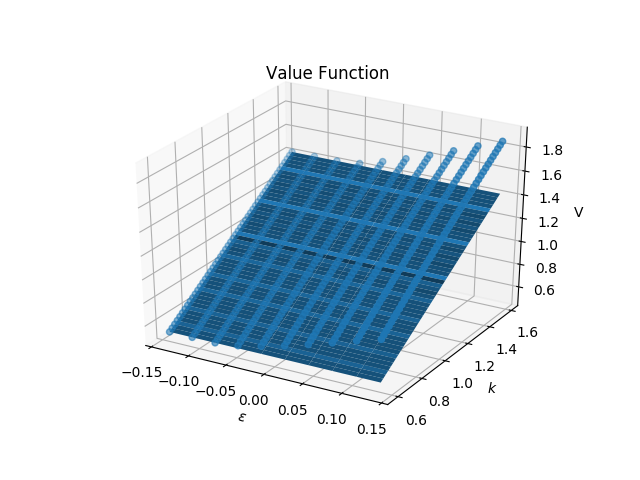

Fraction of exiting firms: 0.008800400230045531


iteration  2
cf val:  0.013


<IPython.core.display.Javascript object>


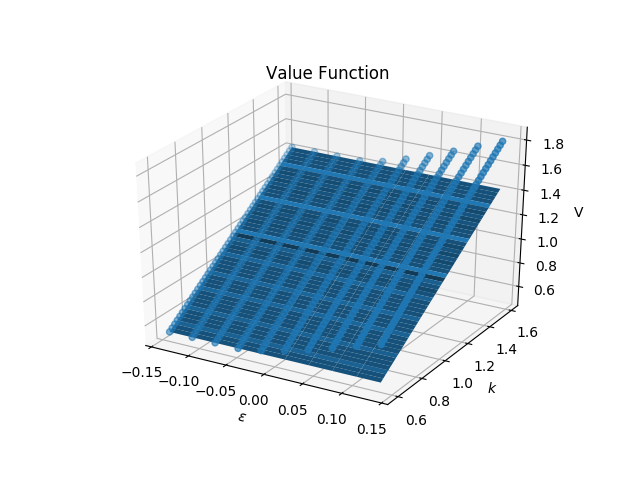

Fraction of exiting firms: 0.05929295813748332


iteration  3
cf val:  0.014


<IPython.core.display.Javascript object>


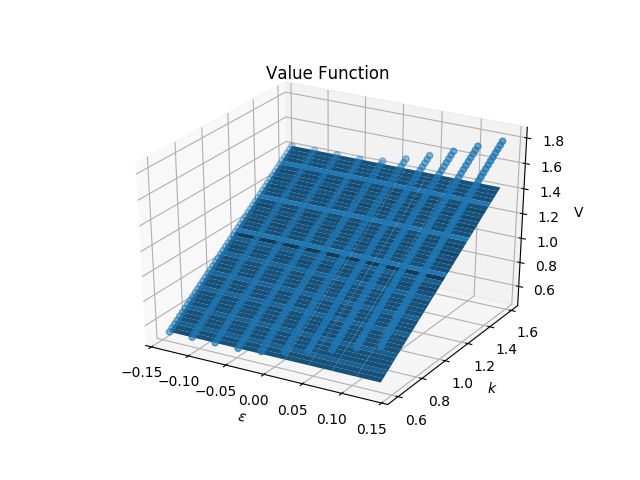

Fraction of exiting firms: 0.06085775753333736


iteration  4
cf val:  0.015


<IPython.core.display.Javascript object>


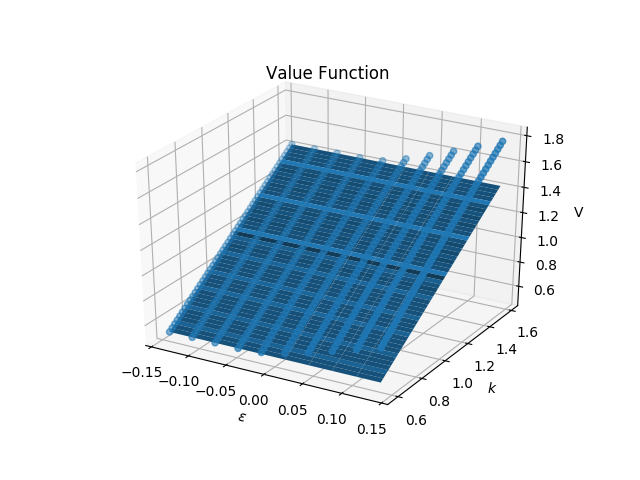

Fraction of exiting firms: 0.1008089715887251


iteration  5
cf val:  0.016


<IPython.core.display.Javascript object>


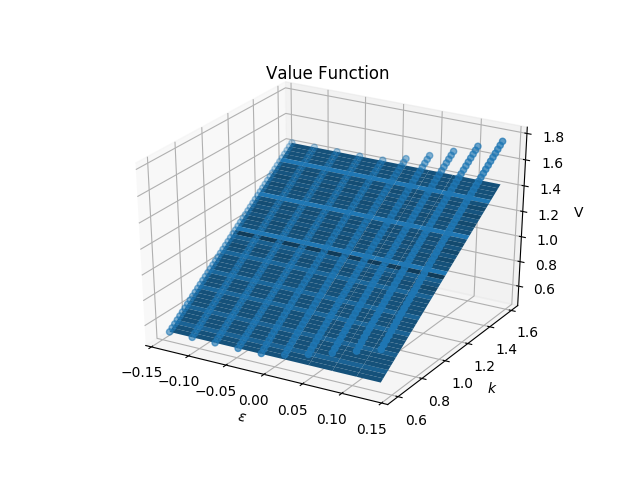

Fraction of exiting firms: 0.20422840896794556




In [55]:
cal_cf, error = calibrate_cf()

In [56]:
cal_cf 

0.015

### (ii) Calibrating exit costs: Calibrate to target average size of new firms to be 40% of average size of all firms

In [58]:
def calibrate_ce():
    
    ce_range = [0.01, 0.05, 0.1, 0.2, 0.5]
    error = 1000
    cal_ce = 0
    iteration = 1
    for ce_val in ce_range:
        
        #print("iteration ", iteration)
        #print("ce val: ", ce_val)
        
        w_guess = 0.9
        w_star = solve_mark_wage(w_guess, ce, cal_cf)
        #print("w_star:", w_star)
        m_guess = 0.05
        m_star = solve_m(m_guess, g, w_star)
        #print("m_star :", m_star)
        
        new_error = abs(m_star - 0.4)
        if new_error < error:
            error = new_error
            cal_ce = ce_val
        
        iteration += 1
    
    return cal_ce, error

In [60]:
cal_ce, error = calibrate_ce()

In [61]:
cal_ce 

0.1